# 封装数据相关操作
- 读取数据并按照空格拆分为token
- 构建词汇表
- 手动实现Dataset
- 手动实现RandomSampler
- 手动实现BatchSampler
- 手动实现DataLoader

In [2]:

from concurrent.futures import ThreadPoolExecutor

import torch


def tokenize_file(input_file):
    all_tokens = []
    with open(input_file, 'r', encoding='utf-8') as file:
        for line_number, line in enumerate(file, 1):
            line = line.strip()
            tokens = nltk.tokenize.word_tokenize(line)
            all_tokens.append(tokens)
    # print(f"Line {line_number}: {all_tokens}")
    return all_tokens


# 构建词汇表
def build_vocab(sentences, specials=['<pad>', '<unk>', '<sos>', '<eos>']):
    vocab = {word: idx for idx, word in enumerate(specials)}
    idx = len(specials)

    for sentence in sentences:
        for word in sentence:
            if word not in vocab:
                vocab[word] = idx
                idx += 1
    return vocab


# 手动实现Dataset
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, src_sentences, tgt_sentences, src_vocab, tgt_vocab, max_len=20):
        self.src_sentences = src_sentences
        self.tgt_sentences = tgt_sentences
        self.src_vocab = src_vocab
        self.tgt_vocab = tgt_vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.src_sentences)

    def __getitem__(self, idx):
        src = self.src_sentences[idx]
        tgt = self.tgt_sentences[idx]

        # 转换为索引
        src_idx = [self.src_vocab.get(word, self.src_vocab['<unk>']) for word in src]
        tgt_idx = [self.tgt_vocab['<sos>']] + [self.tgt_vocab.get(word, self.tgt_vocab['<unk>']) for word in tgt] + [
            self.tgt_vocab['<eos>']]

        # 截断
        if len(src_idx) > self.max_len:
            src_idx = src_idx[:self.max_len]
        if len(tgt_idx) > self.max_len:
            tgt_idx = tgt_idx[:self.max_len - 1] + [tgt_idx[-1]]

        # 填充
        src_padded = src_idx + [self.src_vocab['<pad>']] * (self.max_len - len(src_idx))
        tgt_padded = tgt_idx + [self.tgt_vocab['<pad>']] * (self.max_len - len(tgt_idx))

        return torch.tensor(src_padded), torch.tensor(tgt_padded)


# 手动实现 RandomSampler：随机打乱索引
class RandomSampler:
    def __init__(self, dataset):
        self.indices = list(range(len(dataset)))
        random.shuffle(self.indices)

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)


# 手动实现 BatchSampler：将索引分成批次
class BatchSampler:
    def __init__(self, sampler, batch_size, drop_last=False):
        self.sampler = sampler
        self.batch_size = batch_size
        self.drop_last = drop_last

    def __iter__(self):
        batch = []
        for idx in self.sampler:
            batch.append(idx)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if batch and not self.drop_last:
            yield batch

    def __len__(self):
        total_samples = len(self.sampler)
        batches = total_samples // self.batch_size
        if not self.drop_last and total_samples % self.batch_size != 0:
            batches += 1
        return batches


# 手动实现 DataLoader 的核心功能
class MyDataLoader:
    def __init__(
            self,
            dataset,
            batch_size=1,
            shuffle=False,
            num_workers=0,
            drop_last=False,
    ):
        """
        参数：
            dataset: 自定义的 Dataset 对象
            batch_size: 每个批次的样本数
            shuffle: 是否打乱数据
            num_workers: 使用多少个线程加载数据
            drop_last: 是否丢弃最后不足 batch_size 的批次
        """
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.num_workers = num_workers
        self.drop_last = drop_last

        # 初始化 Sampler 和 BatchSampler
        if shuffle:
            sampler = RandomSampler(dataset)
        else:
            sampler = list(range(len(dataset)))  # 顺序采样

        self.batch_sampler = BatchSampler(sampler, batch_size, drop_last)

    def __iter__(self):
        # 使用多线程加载数据
        if self.num_workers > 0:
            with ThreadPoolExecutor(max_workers=self.num_workers) as executor:
                for batch_indices in self.batch_sampler:
                    # 提交任务到线程池
                    futures = [executor.submit(self.dataset.__getitem__, idx) for idx in batch_indices]
                    # 获取结果
                    batch = [future.result() for future in futures]
                    yield self.collate_fn(batch)
        else:
            # 单线程加载
            for batch_indices in self.batch_sampler:
                batch = [self.dataset.__getitem__(idx) for idx in batch_indices]
                yield self.collate_fn(batch)  # 按需生成批次数据，从而节省内存并提高效率

    def __len__(self):
        return len(self.batch_sampler)

    def collate_fn(self, batch):
        # batch 是一个列表，每个元素是 (input, target)
        inputs = [item[0] for item in batch]
        targets = [item[1] for item in batch]
        return torch.stack(inputs), torch.stack(targets)


# Transformer 代码实现
- 随机种子
- 位置编码
- 多头注意力机制
- 前馈网络
- 编码器层
- 解码器层
- 编码器
- 解码器
- 模型


In [3]:
import math
import random

import numpy as np
import torch


# 设置随机种子保证可重复性
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


set_seed()


# 位置编码
# 位置编码的实现方式有两种：
# 1. 直接使用sin和cos函数对位置进行编码，这种方式比较简单，但是位置编码的维度比较高，需要注意的是，位置编码的维度需要和模型输入的维度一致。
# 2. 使用线性变换对位置进行编码，这种方式需要学习位置编码的权重，但是位置编码的维度比较低，可以和模型输入的维度不一致。
# 这里使用第二种方式，使用线性变换对位置进行编码，位置编码的维度为d_model。
# 位置编码的公式为：
# PE(pos, 2i) = sin(pos / 10000^(2i / d_model))
# PE(pos, 2i+1) = cos(pos / 10000^(2i / d_model))
# 其中，pos为位置，2i和2i+1分别表示sin和cos函数的参数，d_model为模型输入的
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # 添加batch维度
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)


# 多头注意力机制
# 多头注意力机制的实现方式有两种：
# 1. 使用PyTorch自带的nn.MultiheadAttention模块，这种方式比较简单，但是需要注意的是，nn.MultiheadAttention模块只能用于Q、K、V的维度相同的情况，如果Q、K、V的维度不相同，需要使用自定义的MultiheadAttention模块。
# 2. 使用自定义的MultiheadAttention模块，这种方式需要自己实现Q、K、V的线性变换，以及注意力机制的计算，但是可以实现Q、K、V的维度不相同的情况。
# 这里使用第二种方式，使用自定义的MultiheadAttention模块，实现Q、K、V的线性变换，以及注意力机制的计算。
# 多头注意力机制的计算方式为：
# 1. 将Q、K、V分别进行线性变换，得到Q', K', V'
# 2. 计算Q'和K'的注意力得分，注意力得分的计算方式为：
# Q'和K'的内积除以根号d_k
# 3. 将注意力得分除以100000，然后使用softmax函数进行归一化
# 4. 将注意力得分和V'相乘，得到注意力输出
# 5. 将注意力输出进行线性变换，得到最终的注意力输出
# 6. 将多个注意力输出进行拼接，得到最终的注意力输出
# 7. 将最终的注意力输出进行线性变换，得到最终的注意力输出
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = MyLinear(in_features=d_model, out_features=d_model)
        self.W_k = MyLinear(d_model, d_model)
        self.W_v = MyLinear(d_model, d_model)
        self.W_o = MyLinear(d_model, d_model)

    # 注意力机制的计算
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        attention = torch.nn.functional.softmax(scores, dim=-1)
        output = torch.matmul(attention, V)
        return output, attention

    # 将Q、K、V分别进行线性变换，得到Q', K', V'
    def split_heads(self, x):
        # 输入x维度 (batch_size, seq_len, d_model)
        batch_size, seq_len, d_model = x.size()
        # 输出维度 (batch_size, num_heads, seq_len, d_k)
        return x.view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)

    # 将多个注意力输出进行拼接，得到最终的注意力输出
    def combine_heads(self, x):
        batch_size, _, seq_len, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_len, self.d_model)

    # 注意力机制的计算
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        attention_output, attention_weights = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attention_output))
        return output, attention_weights


# 前馈网络
class FeedForward(torch.nn.Module):
    def __init__(self, d_model, dim_feedforward, dropout=0.1):
        super(FeedForward, self).__init__()
        # TODO 实现不一样
        self.linear1 = MyLinear(d_model, dim_feedforward)
        self.dropout = torch.nn.Dropout(dropout)
        self.linear2 = MyLinear(dim_feedforward, d_model)

    def forward(self, x):
        return self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(x))))


# 编码器层
class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, dim_feedforward, dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)

    def forward(self, x, src_mask):
        # 自注意力:TODO _weights?
        attention_output, attention_weights = self.self_attention(x, x, x, src_mask)
        x = self.norm1(x + self.dropout1(attention_output))

        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))

        return x


# 解码器层
class DecoderLayer(torch.nn.Module):
    def __init__(self, d_model, num_heads, dim_feedforward, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(d_model, num_heads)
        # 编码器-解码器注意力
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForward(d_model, dim_feedforward, dropout)
        self.norm1 = torch.nn.LayerNorm(d_model)
        self.norm2 = torch.nn.LayerNorm(d_model)
        self.norm3 = torch.nn.LayerNorm(d_model)
        self.dropout1 = torch.nn.Dropout(dropout)
        self.dropout2 = torch.nn.Dropout(dropout)
        self.dropout3 = torch.nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        # 自注意力
        attention_output, _ = self.self_attention(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attention_output))

        # 编码器-解码器注意力
        attention_output, _ = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout2(attention_output))

        # 前馈网络
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))

        return x


class Encoder(torch.nn.Module):
    def __init__(self, input_dim, d_model, num_heads, dim_feedforward, num_layers, max_len, num_classes, dropout=0.1):
        """
        编码器
        :param input_dim:
        :param d_model:
        :param num_heads:
        :param dim_feedforward:
        :param num_layers:
        :param max_len:
        :param num_classes: 未来扩展，可应用与分类任务
        :param dropout:
        """
        super(Encoder, self).__init__()
        self.embedding = torch.nn.Embedding(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model=d_model, max_len=max_len)
        # Q：为什么用 nn.ModuleList 而不是普通 Python 列表？
        # A：
        # 1. 自动注册为子模块
        #   nn.ModuleList 会将列表中的所有模块（如 nn.Linear、nn.Conv2d 等）自动注册为父模块的子模块（通过 register_module）。
        #   普通 Python 列表 不会自动注册模块，导致这些模块的参数无法被 PyTorch 的 state_dict()、parameters() 或优化器识别。
        # 2. 参数管理
        #   nn.ModuleList 中的模块参数会被自动包含在父模块的 parameters() 中，优化器可以直接访问这些参数。
        #   普通列表 中的模块参数会被忽略，导致训练时参数无法更新。
        # 3. 模型保存与加载
        #   nn.ModuleList 的模块会被自动保存到 state_dict() 中，确保模型加载时参数完整。
        #   普通列表 的模块需要单独处理，否则加载模型时会丢失这些模块的状态。
        self.layers = torch.nn.ModuleList([
            EncoderLayer(d_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.fc_out = MyLinear(d_model, num_classes) if num_classes > 0 else None
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, mask)

        if self.fc_out is not None:
            x = self.fc_out(x)  # 如果是分类任务

        return x


# 解码器
class Decoder(torch.nn.Module):
    def __init__(self, output_dim, d_model, num_heads, dim_feedforward, num_layers, max_len, num_classes, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = torch.nn.Embedding(output_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len)
        self.layers = torch.nn.ModuleList([
            DecoderLayer(d_model, num_heads, dim_feedforward, dropout)
            for _ in range(num_layers)
        ])
        self.fc_out = MyLinear(d_model, output_dim)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for layer in self.layers:
            x = layer(x, enc_output, src_mask, tgt_mask)

        return self.fc_out(x)


class Transformer(torch.nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_heads=8, dim_feedforward=2048,
                 num_layers=6, max_len=100, dropout=0.1):
        """
        Transformer模型
        :param src_vocab_size:
        :param tgt_vocab_size:
        :param d_model:
        :param num_heads:
        :param dim_feedforward:
        :param num_layers:
        :param max_len:
        :param dropout:
        """
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_heads, dim_feedforward, num_layers, max_len, 0, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_heads, dim_feedforward, num_layers, max_len, 0, dropout)

    def encode(self, src, src_mask):
        return self.encoder(src, src_mask)

    def decode(self, tgt, enc_output, src_mask, tgt_mask):
        return self.decoder(tgt, enc_output, src_mask, tgt_mask)

    def forward(self, src, tgt, src_mask, tgt_mask):
        enc_output = self.encode(src, src_mask)
        output = self.decode(tgt, enc_output, src_mask, tgt_mask)
        return output


# 创建掩码
def create_mask(src, tgt):
    # 源序列掩码（填充部分）
    src_seq_len = src.size(1)
    tgt_seq_len = tgt.size(1)
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, src_seq_len]

    # 目标序列掩码（填充部分 + 自回归）
    tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)  # [batch_size, 1, 1, tgt_seq_len]

    # 自回归掩码（下三角矩阵）
    seq_range = torch.arange(tgt_seq_len).unsqueeze(0).expand(tgt_seq_len, tgt_seq_len).to(tgt.device)
    tgt_sub_mask = (seq_range < seq_range.T).unsqueeze(0)  # [1, tgt_seq_len, tgt_seq_len]

    tgt_mask = tgt_pad_mask & tgt_sub_mask

    return src_mask, tgt_mask


class MyLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        """
        自定义线性层（类似 nn.Linear）
        继承nn.Module为了减少call和to的实现

        参数：
            in_features (int): 输入特征维度
            out_features (int): 输出特征维度
            bias (bool): 是否使用偏置（默认 True）
        """
        super(MyLinear, self).__init__()
        # 初始化权重和偏置（使用随机初始化）
        self.weight = torch.nn.Parameter(torch.randn(out_features, in_features))  # 注册为Linear参数
        if bias:
            self.bias = torch.nn.Parameter(torch.randn(out_features))
        else:
            self.register_parameter('bias', None)

    def forward(self, input):
        """
        前向传播：output = input @ weight.T + bias

        参数：
            input (torch.Tensor): 输入张量，形状 [batch_size, in_features]

        返回：
            torch.Tensor: 输出张量，形状 [batch_size, out_features]
        """
        output = torch.matmul(input, self.weight.T)  # 矩阵乘法
        if self.bias is not None:
            output += self.bias  # 加偏置
        return output


# 训练和测试相关封装
- 训练函数
- 评估函数

In [4]:
# 训练函数
def train(model, dataloader, optimizer, criterion, device, clip=1.0):
    model.train()
    total_loss = 0

    for batch_idx, (src, tgt) in enumerate(dataloader):
        src, tgt = src.to(device), tgt.to(device)

        # src维度 ：[batch_size, sequence_length]
        # 创建掩码：维度 [batch_size, num_heads, sequence_length, sequence_length]
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]
        tgt_mask, _ = create_mask(tgt_input, tgt_output)

        optimizer.zero_grad()

        output = model(src, tgt_input, src_mask, tgt_mask)
        output_dim = output.shape[-1]

        # 计算损失（忽略<pad>）
        loss = criterion(output.view(-1, output_dim), tgt_output.reshape(-1))
        loss.backward()

        # 剪裁梯度：防止梯度爆炸，基于参数梯度L2范数对比max_norm
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=clip)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)


# 评估函数
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for src, tgt in dataloader:
            src, tgt = src.to(device), tgt.to(device)

            # 创建掩码
            src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_mask, _ = transformer.create_mask(tgt_input, tgt_output)

            output = model(src, tgt_input, src_mask, tgt_mask)
            output_dim = output.shape[-1]

            # 计算损失（忽略<pad>）
            loss = criterion(output.view(-1, output_dim), tgt_output.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)


# 主方法
- 训练模型
- 测试模型
- 评估模型
- 绘制训练损失曲线
- 评估指标


Epoch 1/50, Train Loss: 38.8512, Time: 5.52s
Epoch 2/50, Train Loss: 26.9814, Time: 4.92s
Epoch 3/50, Train Loss: 17.5851, Time: 4.90s
Epoch 4/50, Train Loss: 12.1024, Time: 4.82s
Epoch 5/50, Train Loss: 9.8548, Time: 5.08s
Epoch 6/50, Train Loss: 8.8394, Time: 4.91s
Epoch 7/50, Train Loss: 8.0950, Time: 4.94s
Epoch 8/50, Train Loss: 7.5203, Time: 4.63s
Epoch 9/50, Train Loss: 7.1712, Time: 4.52s
Epoch 10/50, Train Loss: 6.9758, Time: 4.59s
Epoch 11/50, Train Loss: 6.8845, Time: 4.73s
Epoch 12/50, Train Loss: 6.8496, Time: 4.66s
Epoch 13/50, Train Loss: 6.8326, Time: 5.06s
Epoch 14/50, Train Loss: 6.8206, Time: 4.66s
Epoch 15/50, Train Loss: 6.8138, Time: 4.49s
Epoch 16/50, Train Loss: 6.8075, Time: 5.01s
Epoch 17/50, Train Loss: 6.8076, Time: 5.00s
Epoch 18/50, Train Loss: 6.8058, Time: 4.83s
Epoch 19/50, Train Loss: 6.8045, Time: 5.11s
Epoch 20/50, Train Loss: 6.8039, Time: 4.99s
Epoch 21/50, Train Loss: 6.8032, Time: 4.88s
Epoch 22/50, Train Loss: 6.8055, Time: 5.05s
Epoch 23/50, Tr

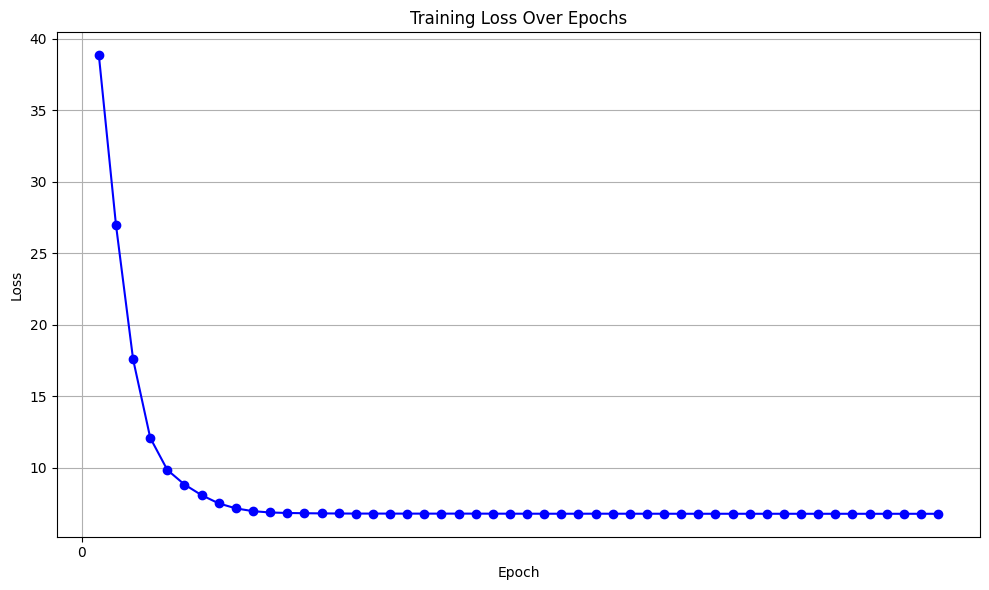

Evaluation Metrics:
Average BLEU Score: 0.0094
Word Accuracy: 0.0717


In [5]:
import time

import matplotlib.pyplot as plt  # 添加matplotlib用于绘图
import nltk
import torch

if __name__ == "__main__":
    d_model = 128  # 模型嵌入维度
    num_heads = 8  # 注意力多头数
    dim_feedforward = 512  # 前馈网络隐藏层维度
    num_layers = 3  # 编码器和解码器层数
    max_len = 20  # 最大序列长度
    dropout = 0.1  # dropout比例
    batch_size = 64  # 批次大小
    num_epochs = 50  # 训练轮数
    learning_rate = 0.001  # 学习率

    # 检查是否有可用的GPU
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # TODO 编码阶段使用apple mps
    device = torch.device("mps" if torch.backends.mps.is_built() and torch.backends.mps.is_available() else "cpu")

    # 训练数据
    train_en_tokens = tokenize_file('corpora/en.txt')
    train_cn_tokens = tokenize_file('corpora/cn.txt')
    # 测试数据
    test_en_tokens = tokenize_file('corpora/en.test.txt')
    test_cn_tokens = tokenize_file('corpora/cn.test.txt')

    # 构建词汇表
    en_vocab = build_vocab(train_en_tokens + test_en_tokens)
    cn_vocab = build_vocab(train_cn_tokens + test_cn_tokens)

    # 创建数据集、加载器
    train_dataset = MyDataset(train_en_tokens, train_cn_tokens, en_vocab, cn_vocab, max_len)
    train_dataloader = MyDataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # 初始化模型
    model = Transformer(len(en_vocab), len(cn_vocab), d_model, num_heads, dim_feedforward, num_layers,
                        max_len, dropout).to(device)

    # 定义优化器和损失函数
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)  # 忽略<pad>的loss

    # 存储训练损失的列表
    train_losses = []

    # 训练模型
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss = train(model, train_dataloader, optimizer, criterion, device)
        end_time = time.time()

        # 记录当前epoch的损失
        train_losses.append(train_loss)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Time: {end_time - start_time:.2f}s")

    # 绘制训练损失曲线
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Over Epochs')  # 训练过程-损失曲线  不能显示中文，使用英文title
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.xticks(range(0, num_epochs + 1, 100))  # 每100个epoch显示一个刻度
    plt.tight_layout()
    plt.show()

    # 测试模型
    test_dataset = MyDataset(test_en_tokens, test_cn_tokens, en_vocab, cn_vocab, max_len)
    test_dataloader = MyDataLoader(test_dataset, batch_size=1)

    # 用于存储评估指标
    total_bleu = 0.0
    total_tokens = 0
    correct_tokens = 0

    with torch.no_grad():
        for src, tgt in test_dataloader:
            src, tgt = src.to(device), tgt.to(device)

            # 创建掩码
            src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
            tgt_input = tgt[:, :-1]
            tgt_output = tgt[:, 1:]
            tgt_mask, _ = create_mask(tgt_input, tgt_output)

            output = model(src, tgt_input, src_mask, tgt_mask)
            output_dim = output.shape[-1]

            # 获取预测结果
            predictions = torch.argmax(output, dim=-1)

            # 将预测和目标转换为token序列
            pred_tokens = predictions.squeeze().tolist()
            target_tokens = tgt.squeeze().tolist()

            # 过滤掉padding token (0)
            pred_tokens = [token for token in pred_tokens if token != 0]
            target_tokens = [token for token in target_tokens if token != 0]

            # 计算BLEU分数，使用第一个预测作为参考
            if len(pred_tokens) > 0 and len(target_tokens) > 0:
                # 将token转换为单词
                pred_words = [list(cn_vocab.keys())[list(cn_vocab.values()).index(idx)] for idx in pred_tokens]
                target_words = [list(cn_vocab.keys())[list(cn_vocab.values()).index(idx)] for idx in target_tokens]

                # 因为训练有限，预测句子和参考句子之间重叠较少，在计算BLEU时使用平滑
                smoothing = nltk.translate.bleu_score.SmoothingFunction()
                bleu = nltk.translate.bleu_score.sentence_bleu([target_words], pred_words,
                                                               smoothing_function=smoothing.method1)
                total_bleu += bleu

            # 计算词级别准确率
            # 只比较非padding的部分
            min_len = min(len(pred_tokens), len(target_tokens))
            correct = sum(1 for i in range(min_len) if pred_tokens[i] == target_tokens[i])
            correct_tokens += correct
            total_tokens += min_len

            # 打印第样本的输入、预测和实际输出  数据较多先不打印
            # print("Input:", [list(en_vocab.keys())[list(en_vocab.values()).index(idx)] for idx in src.squeeze().tolist() if idx != 0])
            # print("Predicted:", pred_words)
            # print("Actual:", target_words)

    # 计算平均BLEU分数
    avg_bleu = total_bleu / len(test_dataloader) if len(test_dataloader) > 0 else 0.0

    # 计算词级别准确率
    word_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0.0

    # 评估指标
    print("Evaluation Metrics:")
    print(f"Average BLEU Score: {avg_bleu:.4f}")
    print(f"Word Accuracy: {word_accuracy:.4f}")
